In [336]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt

In [463]:
%run '../gen_pend.py'

In [ ]:
times, trajs = gen_trajs(10_000, 2., .1, np.pi, 3., .01)

In [415]:
trajs.shape

(10000, 2, 20)

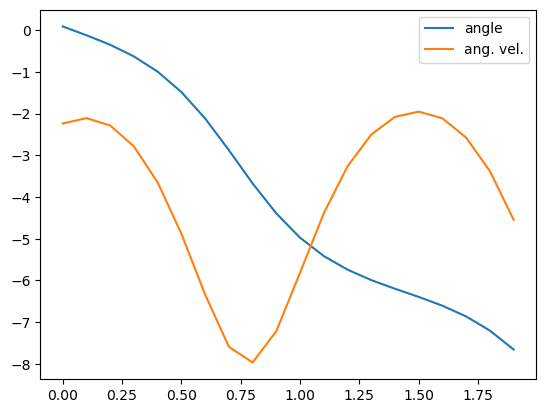

In [416]:
i = np.random.randint(10_000)
plt.plot(times, trajs[i, 0], label='angle');
plt.plot(times, trajs[i, 1], label='ang. vel.')
plt.legend();

Since Pinocchio doesn't give the angles mod 2pi, the angular measurements could get very large. We'll stick to short time-frames so that this doesn't become a problem.

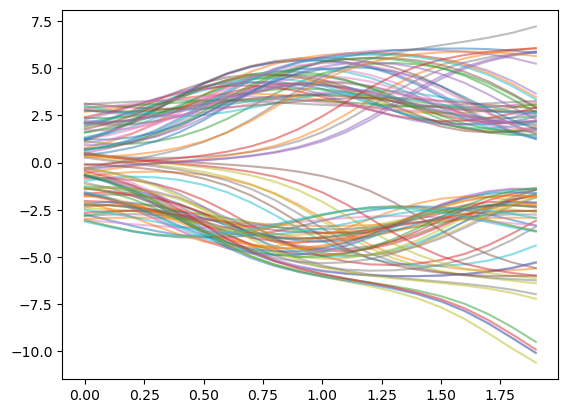

In [417]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)

## Splitting the trajectories into windows

We'll split the trajectories into windows - that way, the MLP architecture won't depend on the length of trajectories to which we apply it.

In [241]:
class TrajWindowsDataset(Dataset):
    def __init__(self, trajs, window):
        super().__init__()
        self.window = window
        self.n_simulations, _, self.n_steps = trajs.shape
        assert window <= self.n_steps
        self.windows_per_traj = self.n_steps - self.window + 1

    def __len__(self):
        return self.n_simulations * self.windows_per_traj

    def __getitem__(self, idx):
        i = idx // self.windows_per_traj
        j = idx % self.windows_per_traj
        return trajs[i, :, j:(j+self.window)]

In [358]:
window = 20
X = TrajWindowsDataset(trajs, window)
dl = DataLoader(X, batch_size=256, shuffle=True)

## MLP

In [418]:
X = torch.tensor(trajs)
dl = DataLoader(X, batch_size=256, shuffle=True)

In [419]:
class TrajEnc(nn.Module):

    def __init__(self, window, n_features, latent_dim):
        super(TrajEnc, self).__init__()

        self.window = window
        self.n_features = n_features

        self.enc = nn.Sequential(
            nn.Linear(window * n_features, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, latent_dim)
        )

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, window * n_features),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x: (bs, n_features, window)
        x = torch.flatten(x, start_dim=1) # x: (bs, n_features * window)
        u = self.enc(x)
        rec = torch.unflatten(2 * np.pi * self.dec(u), dim=1, sizes=(self.n_features, self.window))
        return rec, u

In [420]:
te = TrajEnc(20, 2, 2)

opt = optim.Adam(te.parameters(), lr=7e-5)
loss_fn = nn.MSELoss()

print(f'# params: {sum(p.numel() for p in te.parameters())}')

# params: 20462


In [421]:
n_epochs = 500

for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    # Iterate over batches of data
    for batch_idx, x in enumerate(dl):

        opt.zero_grad()
        rec, lat = te(x)
        loss = loss_fn(rec, x)
        loss.backward()

        opt.step()

        epoch_loss += loss.item() * x.size(0) 

    avg_epoch_loss = epoch_loss / len(dl.dataset)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}")

Epoch [10/500], Loss: 8.5935
Epoch [20/500], Loss: 7.6978
Epoch [30/500], Loss: 7.3464
Epoch [40/500], Loss: 7.1381
Epoch [50/500], Loss: 7.0899
Epoch [60/500], Loss: 6.9988
Epoch [70/500], Loss: 6.9582
Epoch [80/500], Loss: 6.9097
Epoch [90/500], Loss: 6.8248
Epoch [100/500], Loss: 6.7585
Epoch [110/500], Loss: 6.7255
Epoch [120/500], Loss: 6.7077
Epoch [130/500], Loss: 6.6971
Epoch [140/500], Loss: 6.6898
Epoch [150/500], Loss: 6.6833
Epoch [160/500], Loss: 6.6734
Epoch [170/500], Loss: 6.6685
Epoch [180/500], Loss: 6.6649
Epoch [190/500], Loss: 6.6621
Epoch [200/500], Loss: 6.6597
Epoch [210/500], Loss: 6.6573
Epoch [220/500], Loss: 6.6554
Epoch [230/500], Loss: 6.6537
Epoch [240/500], Loss: 6.6519
Epoch [250/500], Loss: 6.6501
Epoch [260/500], Loss: 6.6428
Epoch [270/500], Loss: 6.6379
Epoch [280/500], Loss: 6.6350
Epoch [290/500], Loss: 6.6334
Epoch [300/500], Loss: 6.6320
Epoch [310/500], Loss: 6.6309
Epoch [320/500], Loss: 6.6297
Epoch [330/500], Loss: 6.6286
Epoch [340/500], Lo

In [422]:
with torch.no_grad():
    _, latents = te(X)

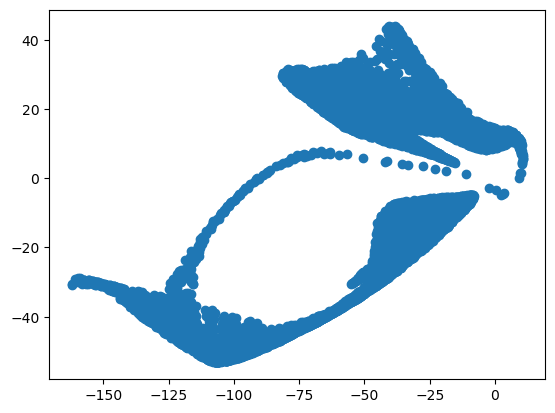

In [423]:
plt.scatter(*latents.numpy().T)

In [428]:
def plot_most_similar(latents, pt, num, ax):
    "Plot the trajectories that have the num closest latents to pt."
    dists = np.linalg.norm(latents - pt, axis=1)
    closest_idxs = np.argsort(dists)[:num]
    for idx in closest_idxs:
        ax.plot(times, trajs[idx, 0, :], alpha=.3)

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_5591/4048237539.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists = np.linalg.norm(latents - pt, axis=1)


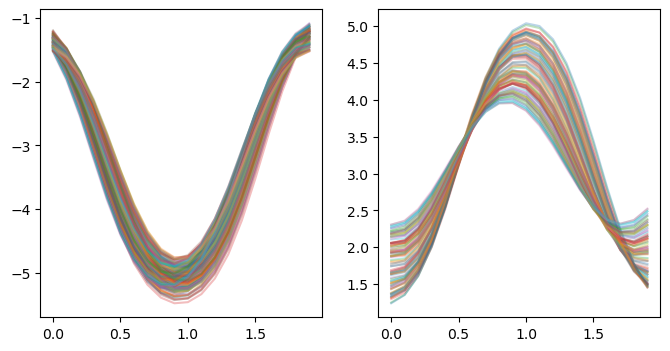

In [433]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_most_similar(latents, np.array([-1., -40.]), 200, axs[0])
plot_most_similar(latents, np.array([-50, 20]), 100, axs[1])

In [561]:
_, traj_damped = gen_one_traj(2., .1, np.pi / 4, 10., .0)

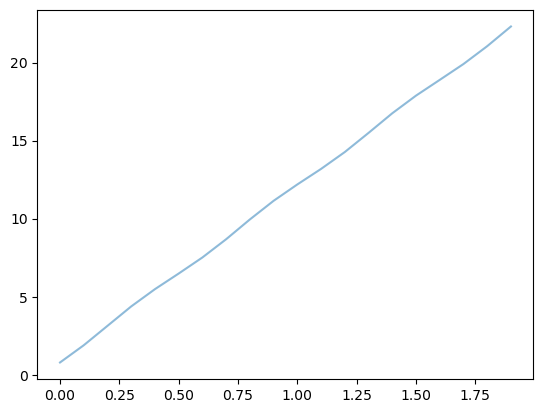

In [562]:
for i in range(1):
    plt.plot(times, traj_damped[i, 0], alpha=.5)

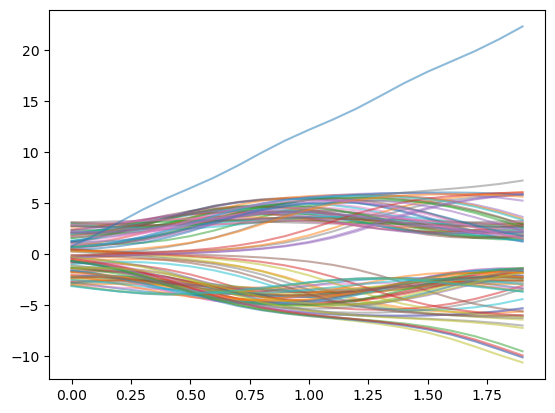

In [563]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, traj_damped[0, 0], alpha=.5)

In [564]:
with torch.no_grad():
    _, latents_damped = te(torch.tensor(traj_damped))

## Importing CD poly nb

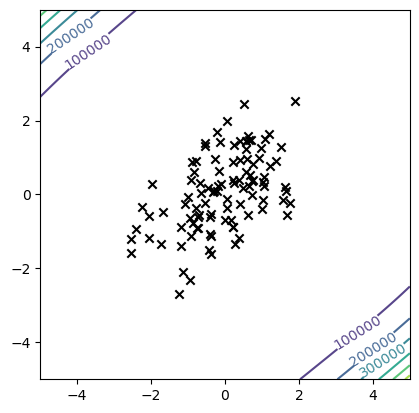

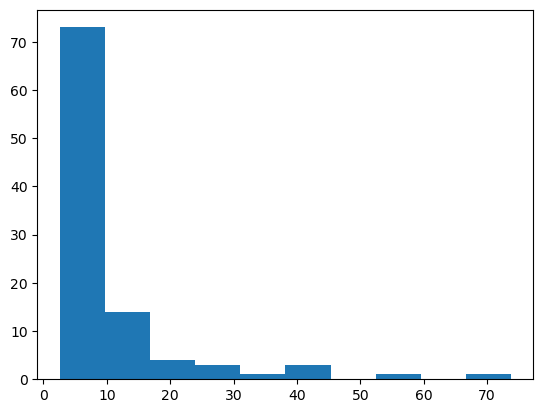

Sample point with most extreme CD poly value: [1.88414474 2.53776333]


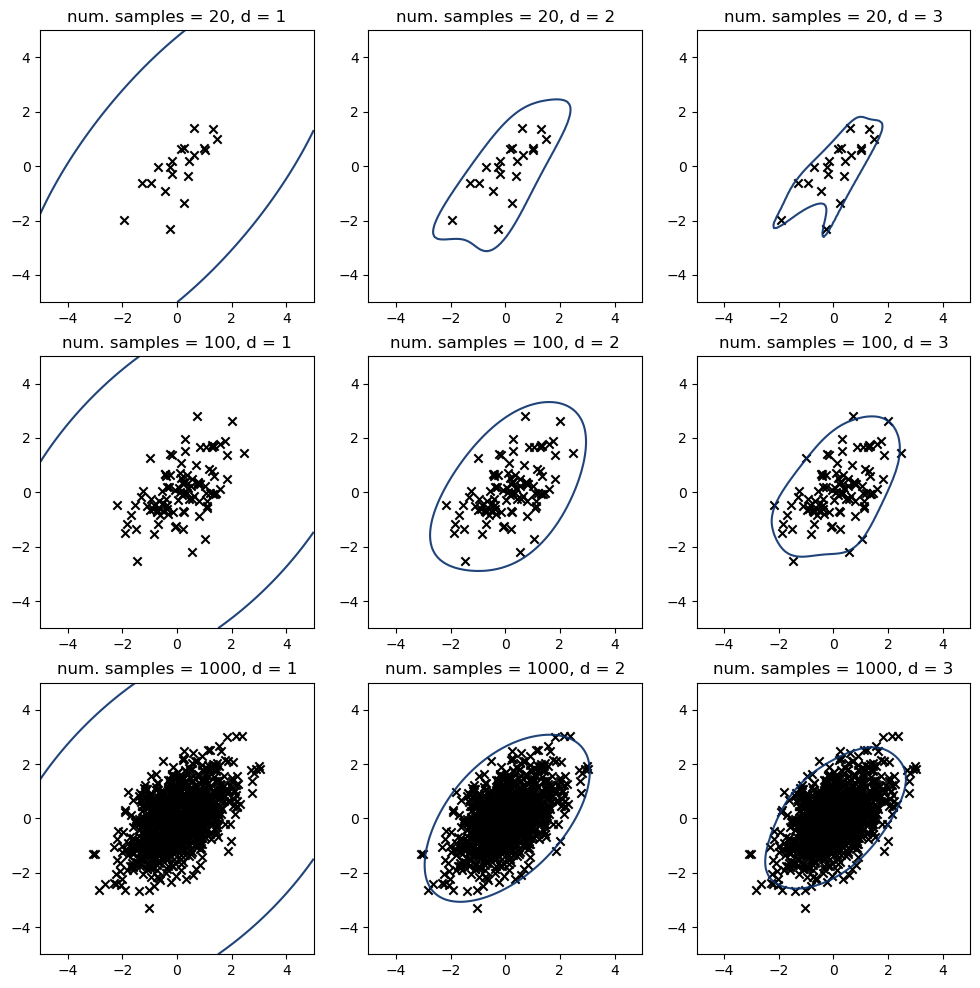

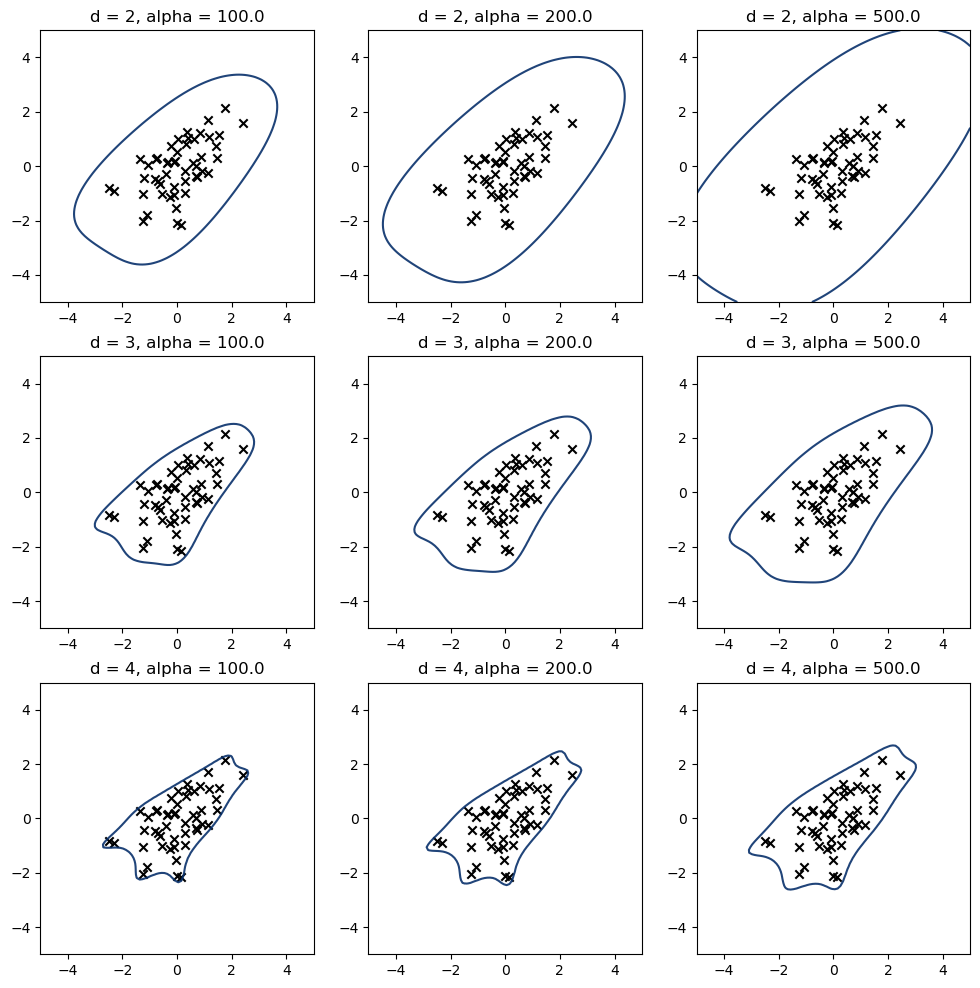

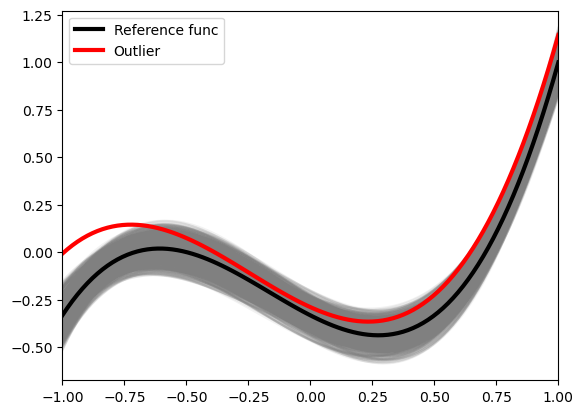

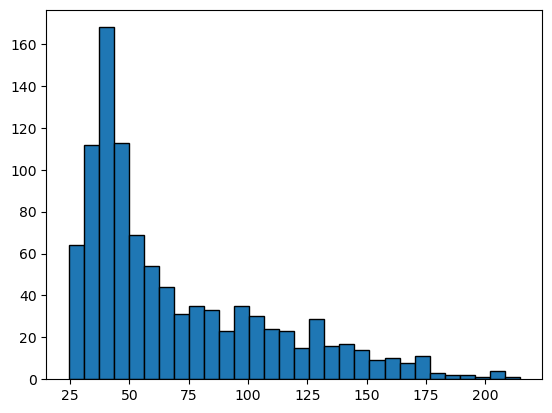

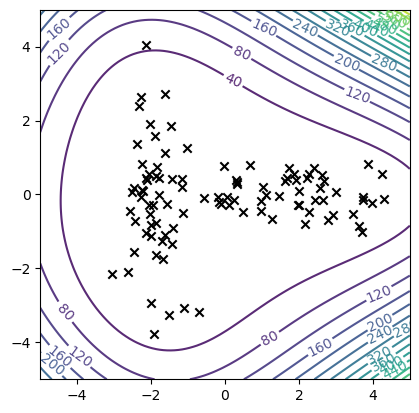

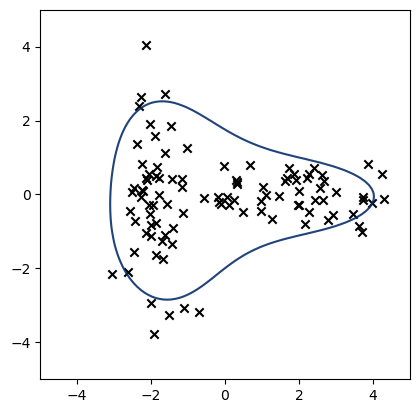

In [498]:
%run '../cd-poly/cd-poly.ipynb'

## Using CD poly

In [565]:
p = CDPolynomial(latents, degree=4)

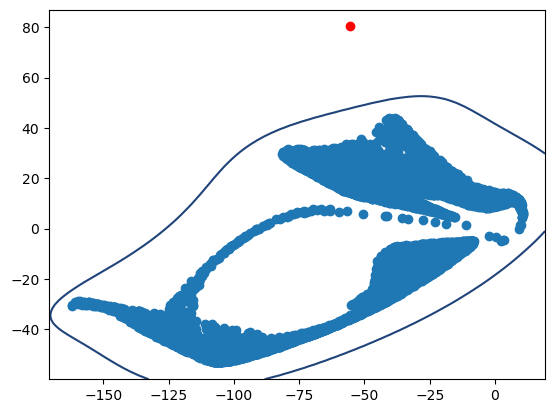

In [566]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_damped.T, color='red')
plot_level_set(p, 1000, ax)